In [8]:
%pip install -q transformers datasets torch scikit-learn matplotlib seaborn optuna wordcloud sentencepiece


Note: you may need to restart the kernel to use updated packages.


Roberta

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv("20191226-reviews.csv")

# Drop rows with missing values
data = data.dropna(subset=["title", "body", "rating"])

# Concatenate Title and Body
data["ReviewText"] = data["title"] + " " + data["body"]

# Map ratings to sentiments
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

data["Sentiment"] = data["rating"].apply(map_rating_to_sentiment)

# Split the dataset
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data["Sentiment"])
val_data, test_data = train_test_split(temp_data, test_size=0.333, random_state=42, stratify=temp_data["Sentiment"])
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row["ReviewText"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(row["Sentiment"], dtype=torch.long),
        }

# Prepare datasets
max_length = 128
train_dataset = SentimentDataset(train_data, tokenizer, max_length)
val_dataset = SentimentDataset(val_data, tokenizer, max_length)
test_dataset = SentimentDataset(test_data, tokenizer, max_length)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to("cuda")

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler
epochs = 3
num_training_steps = epochs * len(train_loader)
from transformers import get_scheduler

# Number of warmup steps (e.g., 10% of total training steps)
num_warmup_steps = int(0.1 * num_training_steps)

# Scheduler initialization with num_warmup_steps
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)
# scheduler = get_scheduler("linear", optimizer=optimizer, num_training_steps=num_training_steps)

# Loss function
loss_fn = CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_loader)}")
    # Evaluation loop
def evaluate(loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["labels"].to("cuda")

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="weighted")
    return accuracy, precision, recall, f1

# Evaluate on test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader)
print(f"Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\tr

Epoch 1, Training Loss: 0.3293348793317857
Epoch 2, Training Loss: 0.21579608281202217
Epoch 3, Training Loss: 0.15915195005634167
Accuracy: 0.9138185032410135, Precision: 0.9092205044795112, Recall: 0.9138185032410135, F1: 0.9111155513804802


Distill-bert

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.33511957659812447
Validation Accuracy: 0.9036982790186745
Epoch 2, Loss: 0.21238356342674206
Validation Accuracy: 0.9039912120102527
Epoch 3, Loss: 0.1233164430044988
Validation Accuracy: 0.9038447455144636
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88      1668
     Neutral       0.45      0.44      0.45       498
    Positive       0.96      0.96      0.96      4561

    accuracy                           0.90      6727
   macro avg       0.76      0.76      0.76      6727
weighted avg       0.90      0.90      0.90      6727



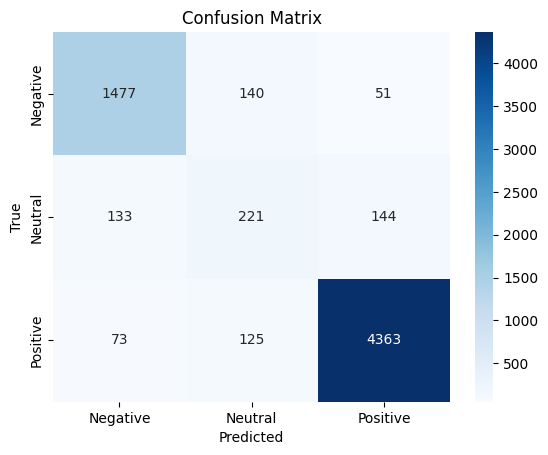

In [6]:
#from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# Mount Google Drive
#drive.mount('/content/drive')

# Load dataset (update file path if necessary)
file_path = '20191226-reviews.csv'  # Update this path
data = pd.read_csv(file_path)

# Preprocessing
data = data.dropna(subset=['title', 'body', 'rating'])
data['ReviewText'] = data['title'] + ' ' + data['body']
data['Sentiment'] = data['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
data = data[['ReviewText', 'Sentiment']]

# Train, test, validation split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['ReviewText'], data['Sentiment'], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.33, random_state=42
)

# Tokenizer setup
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and data loaders
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Loss function
loss_fn = CrossEntropyLoss()

# Training loop
def train_model():
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_preds, val_labels_all = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                val_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
        print("Validation Accuracy:", accuracy_score(val_labels_all, val_preds))

train_model()

# Testing
model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        test_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels_all, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(test_labels_all, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # Save model and tokenizer
# output_dir = "/content/drive/My Drive/distilbert_sentiment_model"
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# print(f"Model and tokenizer saved to {output_dir}")


XLNet

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.34340763016701936
Validation Accuracy: 0.9080922738923471
Epoch 2, Loss: 0.23546293429501564
Validation Accuracy: 0.9125595020139143
Epoch 3, Loss: 0.1539618690020295
Validation Accuracy: 0.9092640058586599
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.91      0.89      1668
     Neutral       0.49      0.46      0.48       498
    Positive       0.97      0.95      0.96      4561

    accuracy                           0.91      6727
   macro avg       0.77      0.78      0.77      6727
weighted avg       0.90      0.91      0.90      6727



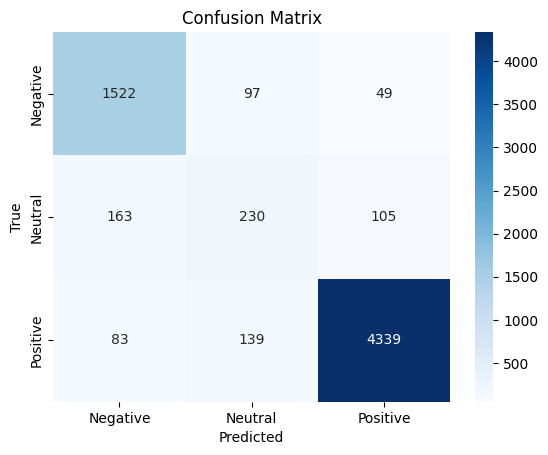

In [1]:
#from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# Mount Google Drive
# drive.mount('/content/drive')

# # Load dataset (update file path if necessary)
file_path = '20191226-reviews.csv'  # Update this path
data = pd.read_csv(file_path)

# Preprocessing
data = data.dropna(subset=['title', 'body', 'rating'])
data['ReviewText'] = data['title'] + ' ' + data['body']
data['Sentiment'] = data['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
data = data[['ReviewText', 'Sentiment']]

# Train, test, validation split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['ReviewText'], data['Sentiment'], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.33, random_state=42
)

# Tokenizer setup
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and data loaders
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Loss function
loss_fn = CrossEntropyLoss()

# Training loop
def train_model():
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_preds, val_labels_all = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                val_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
        print("Validation Accuracy:", accuracy_score(val_labels_all, val_preds))

train_model()

# Testing
model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        test_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels_all, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(test_labels_all, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # Save model and tokenizer
# output_dir = "/content/drive/My Drive/xlnet_sentiment_model"
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# print(f"Model and tokenizer saved to {output_dir}")
